# The Tampa Bay Times and school performance

**Story:** [The story](http://www.tampabay.com/projects/2015/investigations/pinellas-failure-factories/), and [a critique](https://rogueedu.blogspot.com/2015/08/fcat-reading-scores-only-two-of-five.html)

**Author:** A million people, but I believe Nathaniel Lash did the data analysis

**Topics:** Linear Regression, Residuals

**Datasets**

* **0066897-gr04_rsch_2014.xls:** 4th grader pass rates for standardized tests, from Florida Dept of Education
* **FRL-1314-School-Web-Survey-3-Final.xls:** Free and reduced price lunch data, from Florida Dept of Education
* **MembershipSchoolRaceGender1415.xls:** School population by gender, from Florida Dept of Education

# What's the story?

We're trying to see what kind of effect race and poverty have on school test score data. Their actual story doesn't include a regression, but they used one behind the scenes for research.

## Imports

You'll want pandas and seaborn. You'll want want to set pandas to display a lot of columns and rows at a time.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as pt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
pd.set_option("display.max_columns",100)

In [3]:
#setting file path variables
lunch="data\FRL-1314-School-Web-Survey-3-Final.xls"
race="data\MembershipSchoolRaceGender1415.xls"
scores="C:/Users/Anuja/Downloads/HW3-extra_credit/data/0066897-gr04_rsch_2014.xls"

# Reading in our test scores data

While we have a lot of options for what tests we can use, let's stick with reading scores.

* **Tip:** There's a lot of junk up at the file, so you'll want to skip a few of those rows.
* **Tip:** Ouch, even if we skip rows there are still a couple bad ones - the "Number of possible points" and "STATE TOTALS" rows. Get rid of them, too. You can drop them after you've read the data in, if you'd like.
* **Tip:** Sometimes the school number starts with `0`, but pandas will drop it if it thinks the column is an integer. Tell `.read_csv` to read the column in as a string, instead.

In [4]:
import xlrd
scores_df=pd.read_excel(scores, skiprows=10, dtype={"School Number":str, "District Number":str}, na_values="*")

In [5]:
#Dropping the first two rows which contain aggregates/labels.
scores_df=scores_df.drop([0,1] ,axis=0)

In [6]:
#Looking at the dataset 
scores_df.head(2)
scores_df.tail(2)
scores_df.shape

(2207, 17)

### Getting an average

Try to get the median of the `Percentage Passing (Achievement Levels 3 and Above)` column. Oof, it doesn't work! Take a look at your data and see if there's something that needs to be done with `na_values`.

In [7]:
scores_df["Percentage Passing (Achievement Levels 3 and Above)"].median()

58.0

### Confirm that you have 2207 rows and 17 columns, and that the first school is CHARLES W. DUVAL ELEM SCHOOL

In [8]:
scores_df.shape

(2207, 17)

In [9]:
#dropping unnecessary columns
scores_df=scores_df.drop(columns=["District Name","Number of Students","Mean  Developmental Scale Score ", 1,2,3,4,5,"Vocabulary","Reading Application","Literary Analysis: Fiction and Nonfiction","Informational Text and Research Process"])

In [10]:
#renaming key columns
scores_df=scores_df.rename(columns={
    "Grade":"stu_grade",
    "District Number":"dist_id",
    "School Number":"sch_id",
    "School Name":"sch_name",
    "Percentage Passing (Achievement Levels 3 and Above)":"pct_passed"
})

In [11]:
scores_df=scores_df.reset_index(drop=True)

In [12]:
lunch_df=pd.read_excel(lunch, sheet_name="School", skiprows=4, dtype={"District Number":str, "School #":str}, na_values="*")

In [13]:
lunch_df=lunch_df.drop(0, axis=0)

In [14]:
lunch_df=lunch_df.rename(columns={
    "Eligible for Free or Reduced Price Lunch":"eligible_free_lunch",
    "Unnamed: 6":"eligible_reduced_lunch",
    "Unnamed: 7":"eligible_provision_2",
    "Unnamed: 8":"eligible_cep",
    "School #":"sch_id",
    "School Name":"sch_name",
    "District Number":"dist_id",
    "District":"dist_name"
})

In [15]:
#Cleaning the dataset to match the scores dataset
#Pre-fixing 0s to the district number and school number
lunch_df["dist_id"]=lunch_df["dist_id"].str.zfill(2)
lunch_df["sch_id"]=lunch_df["sch_id"].str.zfill(4)

## Calculating a column

Let's add in a new column that is the percent of students who are eligible for free or reduced-price lunch.

* Free, reduced price, provision 2, and CEP direct cert are all kinds of reduced lunch.
* Total members it the total number of students at the school.
* **Tip:** If you get an error, read your error message. Check the datatype of your columns, and take a look at your dataset. Maybe you need to add an `na_values` to your `read_excel` to deal with something in there?

In [16]:
lunch_df["eligible_free_lunch"]=lunch_df["eligible_free_lunch"].astype(float)
lunch_df["eligible_reduced_lunch"]=lunch_df["eligible_reduced_lunch"].astype(float)
lunch_df["eligible_provision_2"]=lunch_df["eligible_provision_2"].astype(float)
lunch_df["eligible_cep"]=lunch_df["eligible_cep"].astype(float)
lunch_df["Total Members"]=lunch_df["Total Members"].astype(float)

In [17]:
lunch_df["pct_eligible_lunch"]=((lunch_df["eligible_free_lunch"]+lunch_df["eligible_reduced_lunch"]+lunch_df["eligible_provision_2"]+lunch_df["eligible_cep"])/lunch_df["Total Members"])*100

In [18]:
#Dropping unrequired columns
lunch_df=lunch_df.drop(columns=["dist_name","Total Members","eligible_free_lunch","eligible_reduced_lunch","eligible_provision_2","eligible_cep"])

In [19]:
lunch_df.reset_index(inplace=True, drop=True)

## Fixing district and school numbers

Even if you specify `dtype` when you're reading in this data, it still drops the leading `0`s that you see in Excel for the district and school numbers. Use `.str.pad` to add them back in.

* **Tip:** School numbers should be 4 characters long, district number should be 2 characters.

In [20]:
#Done above

### Confirm you have 3987 rows and 10 columns

In [21]:
lunch_df.shape

(3987, 4)

# Read in race data

* **Tip:** Beware! The file uses a space `' '` instead of an empty string `''` when having missing data, so you might want to let `pd.read_excel` know about that special kind of missing data.

In [22]:
race_df=pd.read_excel(race, skiprows=4, na_values=[" ","*"], dtype={"School #":str,"District #": str})

In [23]:
#Renaming columns
race_df=race_df.rename(columns={
    "District #":"dist_id",
    "School #": "sch_id",
    "District":"dist_name",
    "School ":"sch_name"
})



## These columns are stupid

If you look at the column names with `df.columns`, you'll see the they have extra spacs after them. This is terrible! 

You can use something like `race.columns = race.columns.str.strip()` to fix that, then columns will behave properly.

In [24]:
#Renamed above

## Cleaning up race counts

When a school has no students of a certain race, it just doesn't put anything in the column. This means a lot of `NaN` values that should be zeros! Fill in those `NaN` values with 0.

In [25]:
race_df=race_df.fillna(0)

## Finding the totals

One row for each school is the `TOTAL` row, that adds up all the other rows and provides an aggregate. Instead of adding ourselves, let's try to use this row.

First, try to filter to only look at the total row for each school.

In [26]:
race_df.sch_name=race_df.sch_name.replace("SCHOOL TOTALS", np.nan).fillna(method="ffill")

It doesn't list the school's name!

There are a lot of ways to fix this, but my favorite is to replace all of the instances of `"SCHOOL TOTAL"` with `NaN`, then have pandas copy down the value from above it. You can use this code:

```python
race.School = race.School.replace("SCHOOL TOTALS", np.nan).fillna(method='ffill')
```

Now let's try again to see the school totals.

In [27]:
race_df[race_df.Grade=="TOTAL"]

,dist_id,dist_name,sch_id,sch_name,Grade,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total
14,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,TOTAL,3.0,196.0,10.0,1.0,0.0,0.0,7.0,102.0,115.0,217.0
29,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,TOTAL,214.0,173.0,108.0,76.0,1.0,0.0,30.0,297.0,305.0,602.0
44,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHL,TOTAL,161.0,182.0,44.0,37.0,2.0,0.0,49.0,247.0,228.0,475.0
59,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUD.CTR.,TOTAL,22.0,64.0,2.0,0.0,0.0,0.0,8.0,20.0,76.0,96.0
74,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,TOTAL,28.0,276.0,3.0,1.0,0.0,1.0,16.0,152.0,173.0,325.0
89,01,ALACHUA,0081,SIDNEY LANIER CENTER,TOTAL,54.0,83.0,13.0,3.0,0.0,0.0,6.0,55.0,104.0,159.0
104,01,ALACHUA,0082,HOSPITAL HOMEBOUND,TOTAL,25.0,14.0,4.0,0.0,0.0,0.0,0.0,17.0,26.0,43.0
119,01,ALACHUA,0091,LITTLEWOOD ELEMENTARY SCHOOL,TOTAL,290.0,197.0,88.0,25.0,1.0,0.0,40.0,290.0,351.0,641.0
134,01,ALACHUA,0101,W. A. METCALFE ELEMENTARY SCHO,TOTAL,36.0,481.0,7.0,2.0,1.0,2.0,12.0,246.0,295.0,541.0
149,01,ALACHUA,0111,JOSEPH WILLIAMS ELEM. SCHOOL,TOTAL,77.0,410.0,13.0,45.0,0.0,3.0,20.0,268.0,300.0,568.0


### Create a new dataframe that is only the 'TOTAL' rows, and confirm it is 3992 rows and 15 columns

In [28]:
totals=race_df[race_df.Grade=="TOTAL"]

totals.columns

Index(['dist_id', 'dist_name', 'sch_id', 'sch_name', 'Grade', 'White',
       'Black or African American', 'Hispanic/Latino', 'Asian',
       'Native Hawaiian or Other Pacific Islander',
       'American Indian or Alaska Native', 'Two or More Races', 'Female Total',
       'Male Total', 'Total'],
      dtype='object')

In [29]:
totals.shape

(3992, 15)

### Adding in percentages

Create a new column called `pct_black` that is the percentage of black students.

* **Tip:** If this isn't working, think about how you fixed a similar problem with lunch data up above

Typically you'd take a larger view of race issues, but in this case we're just trying to reproduce what was done by others.

In [30]:
totals["pct_black"]=(totals["Black or African American"])/(totals["Black or African American"]+totals["White"]+totals["Hispanic/Latino"]+totals["Asian"]+totals["Native Hawaiian or Other Pacific Islander"]+totals["American Indian or Alaska Native"]+totals["Two or More Races"])*100

C:\Users\Anuja\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
#Dropping unrequired columns
totals=totals.drop(columns=["Grade",'White',
       'Black or African American', 'Hispanic/Latino', 'Asian',
       'Native Hawaiian or Other Pacific Islander',
       'American Indian or Alaska Native', 'Two or More Races', 'Female Total',
       'Male Total', 'Total',"dist_name"])

In [32]:
#Re-setting index
totals.reset_index(inplace=True, drop=True)

### Confirm that your dataframe has 3992 rows and 16 columns

In [33]:
totals.shape

(3992, 4)

## Doing our merging

We need to merge them, but **school numbers repeat in difference districts.** You'll need to join on district AND school number to successfully perform each merge.

In [34]:
df=scores_df.merge(lunch_df, on=["dist_id","sch_id","sch_name"]).merge(totals, on=["dist_id","sch_id","sch_name"])

 ### Confirm that you have around 2189 schools and 43 columns

If you have a lot more, it's probably because you merged on your original race dataframe instead of just the totals.

In [35]:
uid=df["dist_id"]+df["sch_id"]

In [36]:
uid.nunique()

1601

In [37]:
df.columns 
#I have already cleaned out my columns, so I have fewer

Index(['stu_grade', 'dist_id', 'sch_id', 'sch_name', 'pct_passed',
       'pct_eligible_lunch', 'pct_black'],
      dtype='object')

# Cleaning up our columns

We're interested in:

* District number
* School number
* Percent passing
* Percent free or reduced lunch
* Percent Black

Let's just select only those columns.

In [38]:
#done above

While you're at it, you should probably rename `Percentage Passing (Achievement Levels 3 and Above)` to `pct_passing` because it's so so long.

In [39]:
#done above

### Converting to percentages

It's really easy to get mixed up later if we don't have our percentage columns as actual percents. Multiply any percentages that go 0-1 by 100 to turn them into 0-100 instead.

* **Tip:** Make sure your numbers are 1-100 after you multiply!

In [40]:
# done above3

# Graphing our data

Use seaborn's `regplot` to plot the relationship between free/reduced lunch and percent passing, and the same with percent black.

* **Tip:** You can use `scatter_kws={'alpha':0.3}` to see things a bit more nicely

Text(0.5, 1.0, 'Relationship b/w pct of students eligible for free lunch and pass pct')

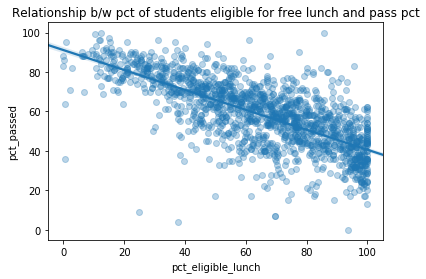

In [41]:
sns.regplot(x="pct_eligible_lunch",y="pct_passed", data=df, scatter_kws={"alpha":0.3}).set_title("Relationship b/w pct of students eligible for free lunch and pass pct")

Text(0.5, 1.0, 'Relationship b/w pct of black students and pass pct')

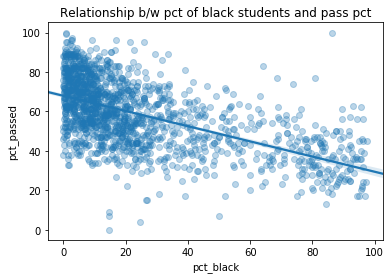

In [42]:
sns.regplot(x="pct_black",y="pct_passed", data=df, scatter_kws={"alpha":0.3}).set_title("Relationship b/w pct of black students and pass pct")

# Linear regression

Now let's be a little more exact: run a linear regression that takes into account both percent black and percent free or reduced.

* **Tip:** Use `.dropna()` to remove missing data
* **Tip:** Remember to use `sm.add_constant`!

In [43]:
# Linear reg model
#x=pct_black, pct_eligible_lunch
#y=pct_passed
df.dropna(subset=["pct_black","pct_eligible_lunch","pct_passed"],inplace=True)
x=df[["pct_black","pct_eligible_lunch"]]
x=sm.add_constant(x)
y=df["pct_passed"]

C:\Users\Anuja\AppData\Local\Programs\Python\Python37-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [44]:
model=sm.OLS(y,x)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pct_passed   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     1044.
Date:                Wed, 24 Jul 2019   Prob (F-statistic):          1.36e-286
Time:                        00:22:46   Log-Likelihood:                -5860.8
No. Observations:                1531   AIC:                         1.173e+04
Df Residuals:                    1528   BIC:                         1.174e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 89.4051      0.819    109.225      0.000      87.799      91.011
pct_black             -0.2009      0.013    -15.778      0.000      -0.226      -0.176
pct_eligible_lunch    -0.4025      0.013    -29.921      0.000      -0.429      -0.376
==============================================================================
Omnibus:                      170.463   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              654.153
Skew:                          -0.490   Prob(JB):                    8.96e-143
Kurtosis:                       6.048   Cond. No.                         215.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
rmse=np.sqrt(result.mse_resid)

11.135308106554714

## Describe the relationship coefficient using "real" words

For example, "For every X change, we get Y change"

In [45]:
## We regressed the dependent variable (pass percentage) on two independent variables - eligibility for free lunches (proxy for poverty) and race being black

# Our equation is y=89.3659-0.2041x1-0.3984x2 where x1 is the pct of students black and x2 is the pct of students eligible for free lunches.

# Both the independent variables have a negative relationship with the dependent variable.

# With a 1% increase in the number of black students in a school, there is 0.2041 or 20.41% decrease in test scores.
# With a 1% increase in the number of students eligible for free lunches, there is a 0.3984 or 39.84% decrease in test scores.


#Robustness:
##1. Error - R sq is ~58% which means that 58% of the change in y can be attributed to x.

##2. RMSE - The root mean square error is ~11.1353 units - i.e., on average a score predicted by our model is 11.1353 units away from the atual score.

# Overperformers and underperformers

The point of the regression is to predict the percent passing, right? We can use `result.predict()` to get the predicted passing rate for each school. Try to run it below: 

In [46]:
df["predicted_y"]=result.predict().reshape(-1,1)
df["residuals"]=result.resid

Now, let's **save that value into a new column**, we can call it `predicted_passing`.

### Confirm that Charles W. Duval had a predicted passing rate of 32.

In [50]:
df[df["sch_name"]=="CHARLES W. DUVAL ELEM SCHOOL"]

,stu_grade,dist_id,sch_id,sch_name,pct_passed,pct_eligible_lunch,pct_black,predicted_y,residuals
0,4,01,0021,CHARLES W. DUVAL ELEM SCHOOL,36.0,95.91195,90.322581,32.657669,3.342331


## Now let's find the difference between the predicted passing rate and the actual passing rate

If we're being stats-y, this is called **the residual**. Save it into a new column called.... `residual`.

* **Tip:** Think real hard about which direction you should be subtracting in.

In [ ]:
# done above

### Find the 10 schools that did much worse than predicted

* PRINCETON HOUSE CHARTER should be the worst, with PEPIN ACADEMIES below that

In [53]:
df.sort_values(by="residuals").head(10)

,stu_grade,dist_id,sch_id,sch_name,pct_passed,pct_eligible_lunch,pct_black,predicted_y,residuals
1010,4,48,0055,PRINCETON HOUSE CHARTER,9.0,25.000000,14.743590,76.381307,-67.381307
761,4,29,6609,PEPIN ACADEMIES,4.0,37.653240,24.747475,69.278976,-65.278976
1597,4,68,0011,DEAF ELEMENTARY SCHOOL (FSDB),7.0,69.491525,14.782609,58.466742,-51.466742
1258,4,50,4037,LEARNING PATH ACADEMY,0.0,93.650794,14.569536,48.786046,-48.786046
1423,4,53,9203,B.E.S.T.,7.0,69.767442,50.000000,51.280737,-44.280737
1334,4,52,3231,RICHARD L. SANDERS SCHOOL,17.0,50.000000,51.886792,58.857593,-41.857593
1325,4,52,2441,CHI CHI RODRIQUEZ ACADEMY,15.0,74.025974,26.760563,54.235443,-39.235443
1395,4,53,1351,POLK AVENUE ELEMENTARY SCHOOL,22.0,66.067864,20.539419,58.688173,-36.688173
1024,4,48,0203,PINECREST CREEK CHARTER,36.0,0.432900,87.214612,71.709969,-35.709969
1015,4,48,0090,UCP EAST CHARTER,35.0,39.552239,13.970588,70.679686,-35.679686


### Find the top 10 schools that did better than predicted

* PARKWAY MIDDLE SCHOOL should be the best, and PATHWAYS should be second

In [54]:
df.sort_values(by="residuals", ascending=False).head(10)

,stu_grade,dist_id,sch_id,sch_name,pct_passed,pct_eligible_lunch,pct_black,predicted_y,residuals
114,4,06,0701,PARKWAY MIDDLE SCHOOL,100.0,85.758706,86.286788,37.554862,62.445138
222,4,06,5372,PATHWAYS ACADEMY K-8 CENTER,83.0,95.652174,64.206642,38.008753,44.991247
211,4,06,5021,SOMERSET NEIGHBORHOOD SCHOOL,77.0,73.611111,80.834915,43.539212,33.460788
1419,4,53,8121,HARTRIDGE ACADEMY,96.0,61.157025,9.243697,62.933903,33.066097
345,4,13,1001,CORAL PARK ELEMENTARY SCHOOL,90.0,77.669903,0.688468,58.006576,31.993424
213,4,06,5031,CHARTER SCHOOL OF EXCELLENCE,77.0,74.817518,68.592058,45.513178,31.486822
472,4,13,5561,FRANCES S. TUCKER ELEM. SCHOOL,75.0,93.253012,41.504854,43.535005,31.464995
425,4,13,4301,PARKVIEW ELEMENTARY SCHOOL,62.0,96.062992,95.601173,31.536442,30.463558
318,4,13,0201,BANYAN ELEMENTARY SCHOOL,82.0,84.880637,0.263158,55.189878,26.810122
151,4,06,2011,CORAL COVE ELEMENTARY SCHOOL,89.0,50.765607,29.561201,63.034528,25.965472


# What problems might our analysis have?

We brought in two things we thought would do a good job covering socioeconomics and demographic patterns. What else might we be missing?

* **Tip:** Pay attention to the names of the schools

In [62]:
# Our R-score is not very high, and our RMSE (~11 points) is too high. We can probably add more control variables.
# There are duplicate school names, althought they have distinct dist and sch ids. I would check if they are actually unique.
# We can also test across grades, and maybe other scores to make a stronger case.

#### The End!